# Task 4 Time Series Analysis
*Alberto Roberto Marinelli, Giacomo Cignoni, Alessandro Bucci*
## Importing Libraries
First we import the libraries necessary to extract the time series


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import pi
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax, TimeSeriesResampler
from statsmodels.tsa.stattools import adfuller 

c:\Users\Kaos1\anaconda3\envs\dataminingenv\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
df = pd.read_csv("../dataset/cleaned_joined_tweets.csv", index_col = 0) 
del df['lang']
del df['bot']
del df['text']
del df['created_at_user']
del df['statuses_count']
del df['id'] #of the tweet

In [3]:
df.created_at = pd.to_datetime(df.created_at, errors='ignore').astype('datetime64[D]')
df.sort_values(by=['user_id', 'created_at'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11277758 entries, 4499433 to 4080317
Data columns (total 8 columns):
 #   Column          Dtype         
---  ------          -----         
 0   user_id         int64         
 1   retweet_count   int64         
 2   reply_count     int64         
 3   favorite_count  int64         
 4   num_hashtags    int64         
 5   num_urls        int64         
 6   num_mentions    int64         
 7   created_at      datetime64[ns]
dtypes: datetime64[ns](1), int64(7)
memory usage: 774.4 MB


Get only the tweets in 2019:

In [4]:
min_date = np.datetime64('2019-01-01 00:00:00')
max_date = np.datetime64('2019-12-31 23:59:59')

df_2019 = df[(df.created_at > min_date) & (df.created_at < max_date)].copy()

For each user we define a series of 365 values initialized at -1, so we define a dataframe of Number_of_users * 365

In [5]:
df_2019.head()

,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at
3343007,722623,1,0,0,0,0,2,2019-01-03
3343357,722623,0,0,2,0,0,0,2019-01-03
3343475,722623,0,0,0,0,0,0,2019-01-03
3343674,722623,0,0,0,0,0,0,2019-01-03
3344173,722623,3,0,0,0,0,1,2019-01-03


## Extract timeseries

### Use pivoting

In [6]:
user_2019 = df_2019.groupby(['user_id', 'created_at']).sum()

Is possible to perform the following operation, sicne in the data cleaning we filled the NaN values.

In [7]:
user_2019['success_score'] = (user_2019.retweet_count + user_2019.reply_count + user_2019.favorite_count) / (user_2019.num_hashtags + user_2019.num_urls + user_2019.num_mentions + 0.1)

Deleting the columns used for the calculation

In [8]:
del user_2019['retweet_count']
del user_2019['reply_count']
del user_2019['favorite_count']
del user_2019['num_hashtags']
del user_2019['num_urls']
del user_2019['num_mentions']

In [9]:
user_2019 = user_2019.pivot_table('success_score','created_at','user_id')
user_2019.rename_axis(columns=None, inplace=True)
user_2019.reset_index(drop=False, inplace=True)

In [10]:
dates = pd.Series(pd.date_range('01-01-2019','31-12-2019')).rename('created_at')

user_2019 = user_2019.merge(dates, how='outer', on='created_at')
user_2019.fillna(-1, inplace=True)
user_2019.set_index('created_at', inplace=True)
user_2019.sort_index(inplace=True)

In [11]:
user_2019.head()

,722623,755746,806975,887281,1382561,3888491,5812422,5820222,6296742,6775342,...,2654027174,2658726517,2662897087,2675560628,2680793168,2682782132,2688868016,2711226669,2717999764,2722021425
created_at,,,,,,,,,,,,,,,,,,,,,
2019-01-01,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.00000,-1.000000,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-02,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.00000,-1.000000,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-03,1.549296,0.0,-1.0,0.0,60.094007,0.0,0.10989,68.395062,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-04,1626.393443,0.0,-1.0,-1.0,0.448065,-1.0,4.83871,575.742574,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-05,1.818182,0.0,-1.0,-1.0,0.370370,-1.0,0.00000,0.000000,-1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [12]:
user_2019.to_csv('../dataset/time_series.csv')

## Preprocessing

### Detect and Remove trends

In [13]:
# Augmented Dickey-Fuller test
# (to provide a quick check and confirmatory evidence that the time series is stationary or non-stationary)
non_stationary_idx_list = []

for col in user_2019.columns:
    adf = adfuller(user_2019[col])
    pvalue = adf[1]
    if pvalue > 0.05:
        non_stationary_idx_list.append(col)

c:\Users\Kaos1\anaconda3\envs\dataminingenv\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\Kaos1\anaconda3\envs\dataminingenv\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\Kaos1\anaconda3\envs\dataminingenv\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\Kaos1\anaconda3\envs\dataminingenv\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\Kaos1\anaconda3\envs\dataminingenv\lib\site-packages\statsmodels\regression\linear_model.py:924: Runtim

In [14]:
len(non_stationary_idx_list)

1142

In [15]:
# Augmented Dickey-Fuller test of example of non sationary timeseries found before
# (to provide a quick check and confirmatory evidence that the time series is stationary or non-stationary)
adf = adfuller(user_2019[non_stationary_idx_list[444]])
adf, pvalue, critical_values = adf[0], adf[1], adf[4]
print(f"ADF: {adf}\np-value: {pvalue}")
print("Critical values:")
for k, v in critical_values.items():
    print(f"{k}: {v}")

ADF: -1.7712827276223182
p-value: 0.3948093133795154
Critical values:
1%: -3.449336554273722
5%: -2.8699055166063085
10%: -2.571226758215748


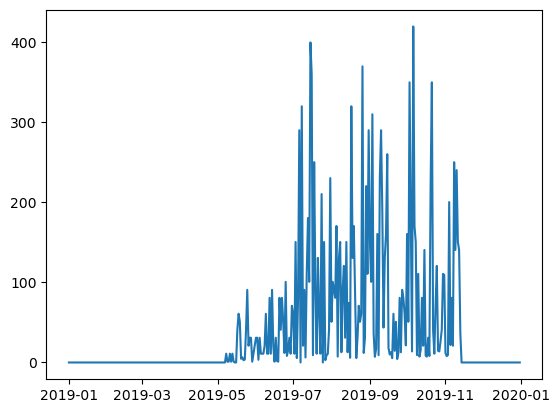

In [16]:
plt.plot(user_2019[non_stationary_idx_list[444]])
plt.show()

Trend removal

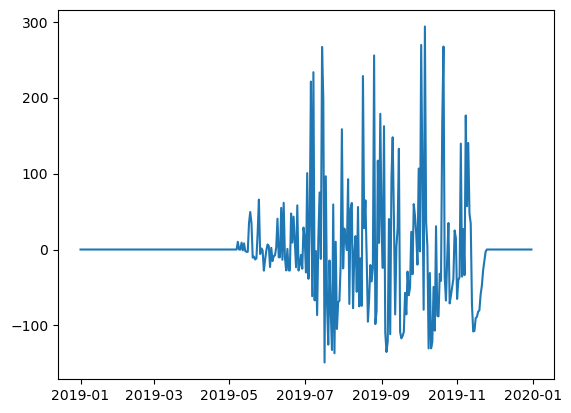

In [17]:
ts_example = user_2019[non_stationary_idx_list[444]]

ts_shift = ts_example - ts_example.rolling(window=12, min_periods=1).mean()
plt.plot(ts_shift)
plt.show()

In [18]:
# Augmented Dickey-Fuller test of example of timeseries after trend removal
# (to provide a quick check and confirmatory evidence that the time series is stationary or non-stationary)
adf = adfuller(ts_shift)
adf, pvalue, critical_values = adf[0], adf[1], adf[4]
print(f"ADF: {adf}\np-value: {pvalue}")
print("Critical values:")
for k, v in critical_values.items():
    print(f"{k}: {v}")

ADF: -5.394945421711191
p-value: 3.470995058865725e-06
Critical values:
1%: -3.449336554273722
5%: -2.8699055166063085
10%: -2.571226758215748


Remove trends for all timeseries with trend

In [19]:
user_2019_detrend = user_2019.copy()

for col in non_stationary_idx_list:
    user_2019_detrend[col] = user_2019_detrend[col] - user_2019_detrend[col].rolling(window=12, min_periods=1).mean()

In [20]:
user_2019_detrend.to_csv('../dataset/time_series_trendless.csv')

### Noise detection
(prova diverse window)

(365,)


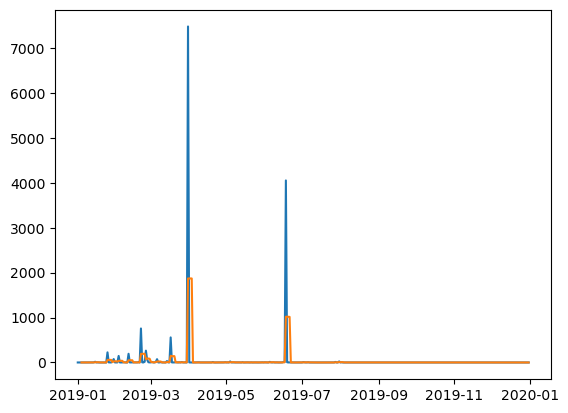

In [21]:
ts_example = user_2019.iloc[:, 29]

print(np.shape(ts_example))

plt.plot(ts_example)
plt.plot(ts_example.rolling(window=4).mean())
plt.show()

To find the best sliding window for the noise we used the mean of the sums of absolute differences between the original timeseries and the smoothed one, then me resorted to the elbow method to choose the best window that 'doesn't smooth too much' the original timeseries.

In [22]:
noise_windows = np.array(range(1,21))

mean_sad_dict = dict()

for window_size in tqdm(noise_windows):
    sum_abs_diff_users = list()

    for user_id in user_2019_detrend.columns:
        sum_abs_diff_single_per_user = np.sum(np.abs(user_2019_detrend[user_id].rolling(window=window_size, center = True, min_periods = 1).mean() - user_2019_detrend[user_id]))
        sum_abs_diff_users.append(sum_abs_diff_single_per_user)
    
    mean_sad_dict[window_size] = np.average(sum_abs_diff_users)

100%|██████████| 20/20 [00:37<00:00,  1.88s/it]


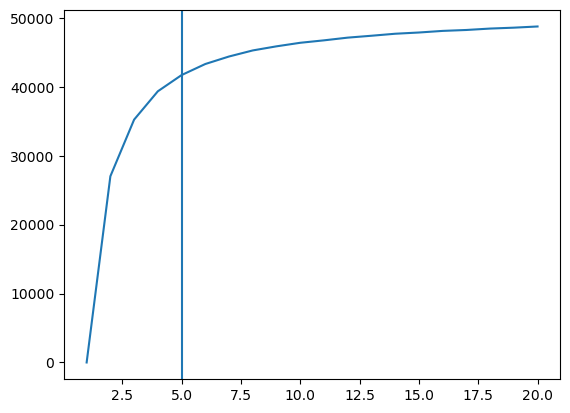

In [23]:
plt.plot(mean_sad_dict.keys(), mean_sad_dict.values())
plt.axvline(5)
plt.show()

The result of this analisys is window size = 5

In [24]:
window_size = 5

In [25]:
def denoiser(df, window_size):
    denoised_df = df.apply(lambda ts : ts.rolling(window=window_size, center = True, min_periods = 1).mean())

    return denoised_df

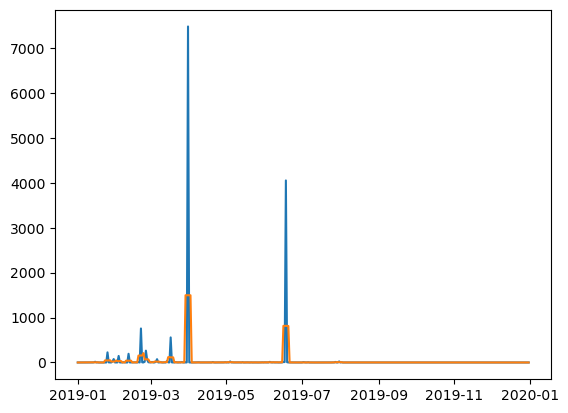

In [26]:
denoised_user_2019 = denoiser(user_2019_detrend,window_size=window_size)
user_id = 29

plt.plot(user_2019.iloc[:, user_id])
plt.plot(denoised_user_2019.iloc[:, user_id])
plt.show()

### Scaler

#### Mean Variance

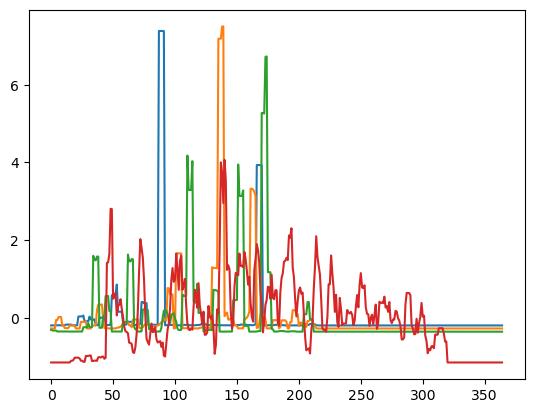

In [27]:
#scaler mean variance
user_2019_std = pd.DataFrame(columns=denoised_user_2019.columns)
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  
for col in denoised_user_2019.columns:
    user_2019_std[col] = scaler.fit_transform(denoised_user_2019[col].values.reshape(1, -1)).flatten()

ts_example_1 = user_2019_std.iloc[:, 29]
ts_example_2 = user_2019_std.iloc[:, 567]
ts_example_3 = user_2019_std.iloc[:, 1000]
ts_example_4 = user_2019_std.iloc[:, 867]
plt.plot(ts_example_1)
plt.plot(ts_example_2)
plt.plot(ts_example_3)
plt.plot(ts_example_4)
plt.show()

## Clustering timeseries

### Shape-Based clustering
#### K-Means

In [35]:
from tslearn.clustering import TimeSeriesKMeans
import random
import warnings

In [36]:
user_list = user_2019_detrend.columns.to_list()

In [51]:
def print_clusters(y, K, model):
    print("k = ", K, "| Clusters =", np.unique(y,return_counts=True)[1], "| Inertia =", model.inertia_)

In [52]:
with warnings.catch_warnings(record=True):
    x = user_2019_detrend.index # forse si elimina
    data_array = np.transpose(user_2019_detrend.values)

    for mtype in (['euclidean', 'dtw']):
        print("Clusters sizes for each K with", mtype, "metric")
        for n_clusters in range(2, 10):
            model = TimeSeriesKMeans(n_clusters=n_clusters, metric='euclidean', max_iter=10)
            model.fit(data_array)
            y = model.predict(data_array)
            print_clusters(y, n_clusters, model)
        print("\n")

Clusters sizes for each K with euclidean metric
k =  2 | Clusters = [6786    1] | Inertia = 20758871919.617355
k =  3 | Clusters = [6747    1   39] | Inertia = 12325449242.787064
k =  4 | Clusters = [6746    1    1   39] | Inertia = 4333338944.3608
k =  5 | Clusters = [6745    1    1   39    1] | Inertia = 3465371425.9354596
k =  6 | Clusters = [6744    1   39    1    1    1] | Inertia = 3377251172.3661175
k =  7 | Clusters = [6713    1   21    1   13    1   37] | Inertia = 2197848337.4533362
k =  8 | Clusters = [6714    1    1   13   36    1   20    1] | Inertia = 2132973376.1335766
k =  9 | Clusters = [6714    1   21    1    1    1   35   12    1] | Inertia = 2008970903.2469616




As we can see from the results of the K-Means, we get multiple singleton clusters, even after all the preprocesssing on the series and for all K values we get a very big cluster with the majority of elements (>98%). The K-Means does not give us a significative clustering.

In [ ]:
'''num_samples_per_cluster = 1
for c in range(n_clusters):
    cluster_index = [i for i, x in enumerate(y) if x == c] 
    random_indexes = np.random.choice(cluster_index, size=num_samples_per_cluster, replace=False)
    user_cluster_sample = user_2019_std.iloc[:,random_indexes]
    
    for id in user_cluster_sample.columns:
        plt.plot(user_cluster_sample[id])

    plt.show()
    '''

#### Hierarchical?

### Feature based clustering

In [73]:
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [74]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [75]:
data_array = np.transpose(user_2019_detrend.values)

data_array_features = [list(calculate_features(x).values())[:-2] for x in data_array]

#### K-Means

In [76]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(data_array_features)

In [77]:
def KMeansFunction (X, n_clusters_list, n_init_value, max_iter_value=300):
    kmeans_list = list()

    for numCluster in tqdm(n_clusters_list):
        # Define and fit K-Means
        kmeans = KMeans(n_clusters=numCluster, n_init=n_init_value, max_iter=max_iter_value)
        kmeans.fit(X)
        kmeans_list.append(kmeans)
    
    return kmeans_list

In [85]:
# Params for kmeans
clusters_list = [x for x in range(1, 20)]
init_value = 10
iter_value = 300

# Get list of kmeans with from the list of possible k
kmeans_list = KMeansFunction (X_minmax, clusters_list, init_value, iter_value)

# Calculate SSE and Silhouette for each kmeans
sse_list = []
silhouette_list = []
for i, kmeans in enumerate(kmeans_list):
    sse_list.append(kmeans.inertia_)
    print_clusters(kmeans.labels_, clusters_list[i], kmeans)
    #print('K:', clusters_list[i], ' - SSE:', kmeans.inertia_, '- SILHOUETTE:')

100%|██████████| 19/19 [00:02<00:00,  7.96it/s]

k =  1 | Clusters = [6787] | Inertia = 70.45101323288414
k =  2 | Clusters = [2302 4485] | Inertia = 36.21118148377967
k =  3 | Clusters = [4476 2271   40] | Inertia = 24.235550070484244
k =  4 | Clusters = [4475 2268   43    1] | Inertia = 18.383023477165576
k =  5 | Clusters = [4473 2271   40    2    1] | Inertia = 12.586138020061817
k =  6 | Clusters = [  70 2271 4403   40    1    2] | Inertia = 10.13701433051232
k =  7 | Clusters = [3623 2207    2   40   69    1  845] | Inertia = 7.75236652667761
k =  8 | Clusters = [ 840 3626   15    2    1   66   44 2193] | Inertia = 6.107166355337339
k =  9 | Clusters = [3629 2193    1   44    2  840   62   15    1] | Inertia = 5.065151102178889
k =  10 | Clusters = [3501 2193   15    1    2   44   37  153    1  840] | Inertia = 4.334192676420697
k =  11 | Clusters = [3523  943   15    1    2   35  130  809    2   36 1291] | Inertia = 3.678480381235159
k =  12 | Clusters = [3521 1184   15    2    1  809   24   36    1  133   26 1035] | Inertia =

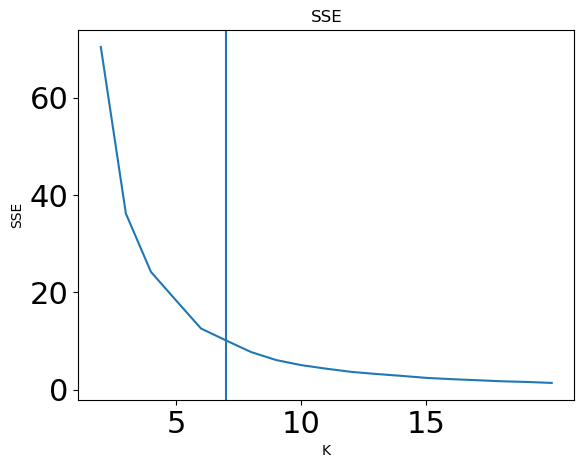

In [88]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(clusters_list[4::5])
plt.title('SSE')
plt.axvline(7)
#plt.yscale('log')
plt.show()

In this case we choose K = 7 as we can deduct from the knee method. We can also see during the execution that from K=>7, there are 3 big clusters.

Plotta time series per ogni cluster

#### Hierachical

In [107]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fclusterdata

In [90]:
scaler = StandardScaler()
X_std = scaler.fit_transform(data_array_features)

In [91]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(data_array_features)

##### With minmax normalization


In [101]:
config_hierarchical_minamx = []

Show generated dendrogram for hierarchical clustering with selected params and the best threshold for that dendrogram.

method: complete, threshold: 0.2, n_clusters: 5

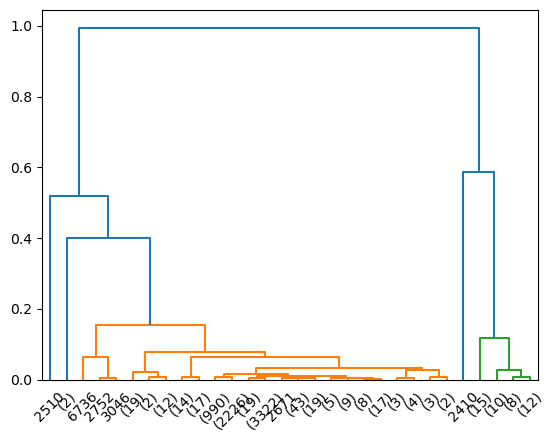

In [102]:
# Generate dendrogram
data_dist = pdist(X_minmax, metric='cosine')
data_link = linkage(data_dist, method='complete', metric='cosine')
res = dendrogram(data_link, color_threshold=0.2, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minamx.append((0.2, 'cosine', 'complete'))

method: ward, threshold:0.8, n_clusters: 2

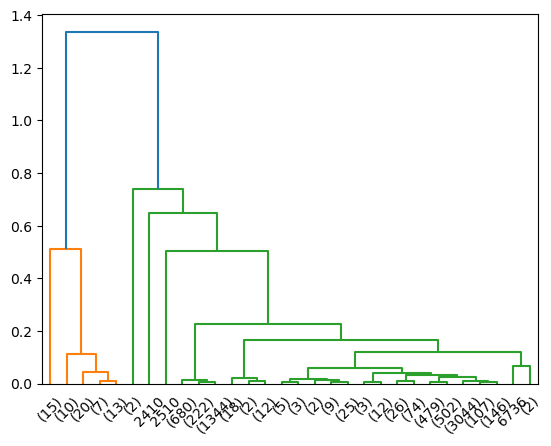

In [103]:
# Generate dendrogram
data_dist = pdist(X_minmax, metric='cosine')
data_link = linkage(data_dist, method='ward', metric='cosine')
res = dendrogram(data_link, color_threshold=0.8, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minamx.append((0.8, 'cosine', 'ward'))

method: average, threshold: 0.2, n_clusters: 5

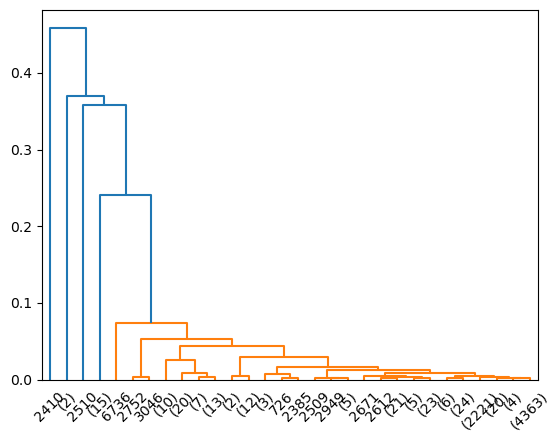

In [104]:
# Generate dendrogram
data_dist = pdist(X_minmax, metric='cosine')
data_link = linkage(data_dist, method='average', metric='cosine')
res = dendrogram(data_link, color_threshold=0.2, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minamx.append((0.2, 'cosine', 'average'))

method: centroid, threshold: 0.2, n_clusters: 5

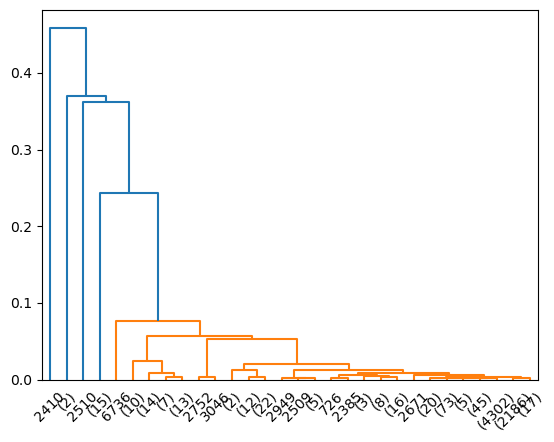

In [105]:
# Generate dendrogram
data_dist = pdist(X_minmax, metric='cosine')
data_link = linkage(data_dist, method='centroid', metric='cosine')
res = dendrogram(data_link, color_threshold=0.2, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minamx.append((0.2, 'cosine', 'centroid'))

Fit clusterings with params found by exploring dendrograms

In [108]:
cluster_list_minmax = []
for treshold, metric_minmax, method_minmax in config_hierarchical_minamx:
    cluster = fclusterdata(X=X_minmax,
     t=treshold , criterion='distance', metric=metric_minmax, method=method_minmax)
     
    cluster_list_minmax.append(cluster)

Calculate Silhouette for each clustering.

In [109]:
for i, clustering in enumerate(cluster_list_minmax):
    treshold, metric, method = config_hierarchical_minamx[i]
    n_clusters = len(np.unique(clustering))
    occ_list = []
    for k in range(1, n_clusters+1):
        occ_list.append(np.count_nonzero(clustering == k))

    try: # Exception in case of num_clusters=1
        silhouette = silhouette_score(X_minmax, clustering)
    except:
        silhouette = np.nan
    print("MINMAX - dist:", metric, ", method:", method, ", SILHOUTTE:", silhouette, ", n_clusters:", n_clusters)
    print('Clusters Size:', occ_list)
    print('\n')

MINMAX - dist: cosine , method: complete , SILHOUTTE: 0.8570957939449932 , n_clusters: 5
Clusters Size: [2, 6738, 1, 45, 1]


MINMAX - dist: cosine , method: ward , SILHOUTTE: 0.824403417979269 , n_clusters: 2
Clusters Size: [65, 6722]


MINMAX - dist: cosine , method: average , SILHOUTTE: 0.8963557606637428 , n_clusters: 5
Clusters Size: [2, 15, 6768, 1, 1]


MINMAX - dist: cosine , method: centroid , SILHOUTTE: 0.8963557606637428 , n_clusters: 5
Clusters Size: [2, 15, 6768, 1, 1]




##### With mean-std normalization


In [133]:
config_hierarchical_std = []

Show generated dendrogram for hierarchical clustering with selected params and the best threshold for that dendrogram.

method: complete, threshold: 1, n_clusters: 7

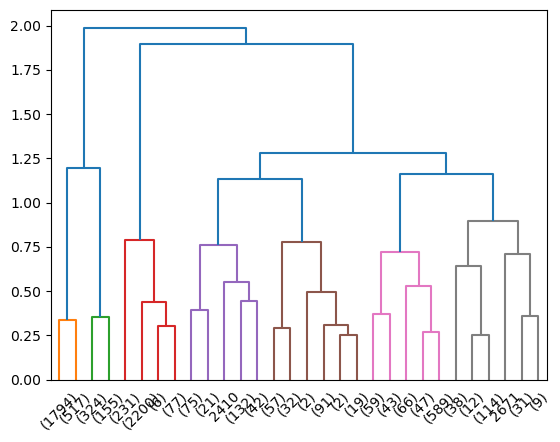

In [134]:
# Generate dendrogram
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='complete', metric='cosine')
res = dendrogram(data_link, color_threshold=1, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((1, 'cosine', 'complete'))

method: ward, threshold: 20, n_clusters: 3

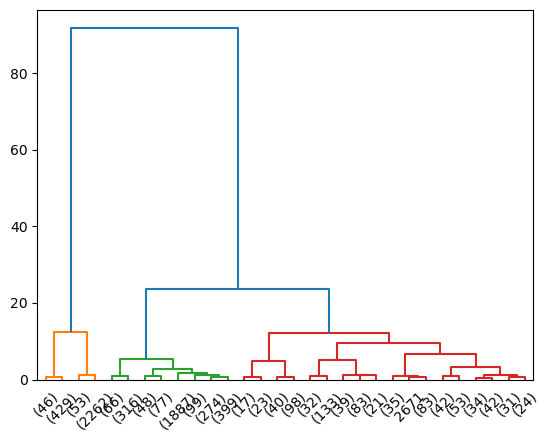

In [135]:
# Generate dendrogram
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='ward', metric='cosine')
res = dendrogram(data_link, color_threshold=20, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((20, 'cosine', 'ward'))

method: average, threshold: 0.6, n_clusters: 6

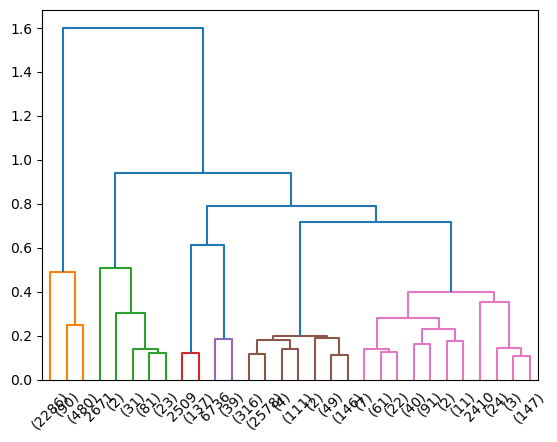

In [136]:
# Generate dendrogram
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='average', metric='cosine')
res = dendrogram(data_link, color_threshold=0.6, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((0.6, 'cosine', 'average'))

method: centroid, threshold: 0.6, n_clusters: 5

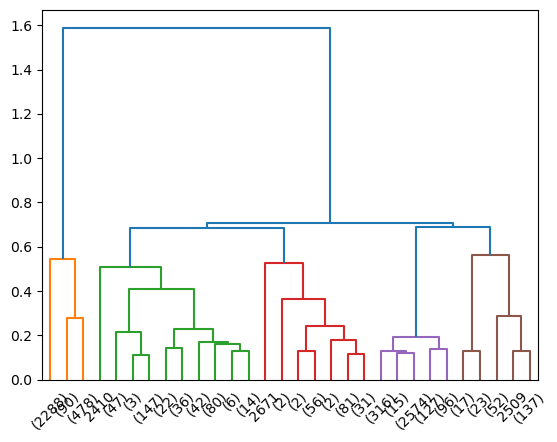

In [137]:
# Generate dendrogram
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='centroid', metric='cosine')
res = dendrogram(data_link, color_threshold=0.6, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((0.6, 'cosine', 'centroid'))

Fit clusterings with params found by exploring dendrograms

In [138]:
cluster_list_std = []
for treshold, metric_std, method_std in config_hierarchical_std:
    cluster = fclusterdata(X=X_std,
     t=treshold , criterion='distance', metric=metric_std, method=method_std)
     
    cluster_list_std.append(cluster)

Calculate Silhouette for each clustering.

In [139]:
for i, clustering in enumerate(cluster_list_std):
    treshold, metric, method = config_hierarchical_std[i]
    n_clusters = len(np.unique(clustering))
    occ_list = []
    for k in range(1, n_clusters+1):
        occ_list.append(np.count_nonzero(clustering == k))

    try: # Exception in case of num_clusters=1
        silhouette = silhouette_score(X_std, clustering)
    except:
        silhouette = np.nan
    print("STD - dist:", metric, ", method:", method, ", SILHOUTTE:", silhouette, ", n_clusters:", n_clusters)
    print('Clusters Size:', occ_list)
    print('\n')

STD - dist: cosine , method: complete , SILHOUTTE: 0.388117931707238 , n_clusters: 7
Clusters Size: [2311, 479, 2514, 271, 203, 804, 205]


STD - dist: cosine , method: ward , SILHOUTTE: 0.5672335254374774 , n_clusters: 3
Clusters Size: [2790, 3166, 831]


STD - dist: cosine , method: average , SILHOUTTE: 0.5976079054108929 , n_clusters: 6
Clusters Size: [2856, 138, 138, 40, 3206, 409]


STD - dist: cosine , method: centroid , SILHOUTTE: 0.581196159782644 , n_clusters: 5
Clusters Size: [2856, 398, 175, 3128, 230]


